### Imports

In [1]:
#official libraries
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import cmath
import random
from scipy import integrate
from scipy.fftpack import fft
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy import signal
import pandas as pd
import time
import torch.nn as nn
import torch.nn.functional as F
import time 
import visdom
from os.path import expanduser

In [2]:
#own files
from lib.utils_general import diff_same_length, get_data_paths
from lib.utils_generate_W import get_grid, gauss_dist, generate_W
from lib.utils_generate_n import n_compl, plot_n
from lib.utils_calc_psi import plot_psi
from lib.utils_generate_data import generate_init_data, plot_sample, generate_corr_data
from lib.utils_initial_dataset import InitialDataset, ToTensor, OneChannel, Normalize, calc_mean_std
from lib.utils_train import get_dataloaders, train_net
from lib.nets import FNN, UNet
from lib.utils_evaluation import DeNorm, plot_prediction, plot_correction
from lib.utils_corrector_dataset import CorrectorDataset, NormalizeCorr, calc_mean_std_corr, ToDevice
from lib.utils_train_corrector import train_corrector
from lib.UNet_featurek import UNet_featurek

In [3]:
torch.cuda.is_available()

False

### Parameter, paths, etc

In [4]:
# ---------------------------------
# choose which mode the prg is in:
# ---------------------------------
do_load_model = True
do_load_model_corr = False
do_train_model = not do_load_model
do_train_model_corr = not do_load_model_corr
do_create_initial_data = False
do_create_corrector_data = True
toy_data = False #if run on GPU machine, set to false
which_model = 'UNet' #FNN / UNet / UNet_old
which_model_corr = 'UNet'
# ---------------------------------

# ---------------------------------
# paths:
# ---------------------------------
home = expanduser("~")

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# models
path_model = 'models/' + which_model + '.pt'
path_model_corr = 'models/' + which_model + '_corr.pt'

# data
path_initial_data, path_corrector_data = get_data_paths(toy_data, device, home)

path_initial_data_diverse = home + '/ml_data/data_initial_diverse/'
path_test_data = home + '/ml_data/data_test/'

# plots
path_plots = 'plots/'
# ---------------------------------

# ---------------------------------
# hyperparameters:
# ---------------------------------
learning_rate = 0.00001
nmbr_epochs = 100
early_stopping = 100
validation_split = 0.2
# ---------------------------------

# ---------------------------------
# data parameters:
# ---------------------------------
half_width = 5
nmbr_points = 10000
if toy_data:
    size_dataset = 8 #if run on GPU machine, set to 5000 (toydata 8)
else:
    size_dataset = 5000

grid, stepsize = get_grid(half_width, nmbr_points)
# ---------------------------------

### Generate Initial Data

In [5]:
if do_create_initial_data:
    generate_init_data(size_dataset, path = path_initial_data, x = grid, dx = stepsize)

50


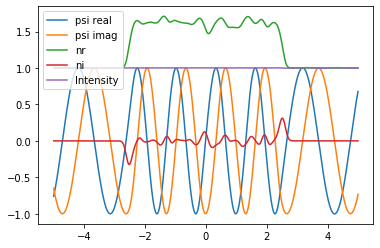

In [6]:
#show that it worked
plot_sample(size_dataset, path = path_initial_data, x = grid, dx = stepsize)

### Create Initial Dataset

In [7]:
nr_mean, nr_std, ni_mean, ni_std = calc_mean_std(size_dataset, path_initial_data)

In [8]:
transform = transforms.Compose([Normalize((nr_mean, ni_mean), (nr_std, ni_std)),
                                    ToTensor(device)
                                   ])

In [9]:
initial_dataset = InitialDataset(csv_file = path_initial_data + 'k_values.csv', 
                               root_dir = path_initial_data,
                               transform = transform)

tensor([ 2.3647, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
       device='cuda:0')
torch.Size([10001])
True


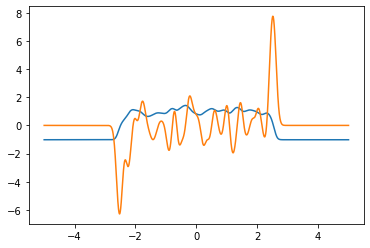

In [10]:
#show that it worked
idx = 6

print(initial_dataset[idx]['k_n_r'])
print(initial_dataset[idx]['k_n_r'].size())
print(initial_dataset[idx]['k_n_r'].is_cuda)

plt.plot(grid,initial_dataset[idx]['k_n_r'].cpu().numpy()[1:])
plt.plot(grid,initial_dataset[idx]['n_i'].cpu().numpy())    

### Create Dataloaders and Model

In [11]:
train_loader, validation_loader = get_dataloaders(initial_dataset, 
                                                  batch_size = 8, 
                                                  validation_split = validation_split, 
                                                  shuffle_dataset = True, 
                                                  random_seed= 42)

In [12]:
#evtl soll nicht ein neues Model erstellt, sondern ein altes geladen werden!

if do_load_model:
    model = torch.load(path_model, map_location=device) # , map_location=device
else:
    #sonst wird jetzt neues Model erstellt
    if which_model == 'FNN':
        model = FNN(n_feature=10001, n_hidden=1000, n_output=10000)
    elif which_model == 'UNet_featurek':
        model = UNet_featurek(device, n_channels=1, n_classes=1, label_len = nmbr_points)
    else:
        model = UNet(n_channels=1, n_classes=1, label_len = nmbr_points)

print(model)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv1d(1, 128, kernel_size=(9,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, a

In [13]:
model.to(device)
next(model.parameters()).is_cuda

True

### Training

In [14]:
if do_train_model:
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model, info = train_net(nmbr_epochs, model, criterion, optimizer,
                            train_loader, validation_loader, early_stopping= early_stopping, path=path_model)

In [15]:
print(info)

NameError: name 'info' is not defined

### Evaluation

In [16]:
plt.rcParams['figure.figsize'] = [15,10]

In [17]:
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv1d(1, 128, kernel_size=(9,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, a

The prediction looks like this...

8.99999982664426


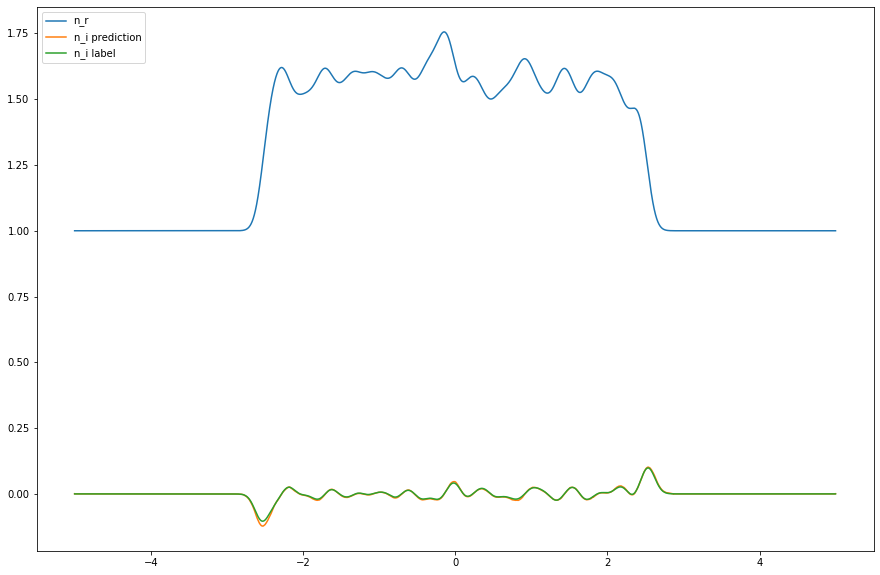

In [18]:
nr, ni, ni_pred, k = plot_prediction(validation_loader, model, grid, 
                                     nr_mean, nr_std, ni_mean, ni_std, 
                                     idx=0, k=None)
plt.savefig(path_plots + which_model + '_Prediction.pdf')

The intensity with the label potential like this...

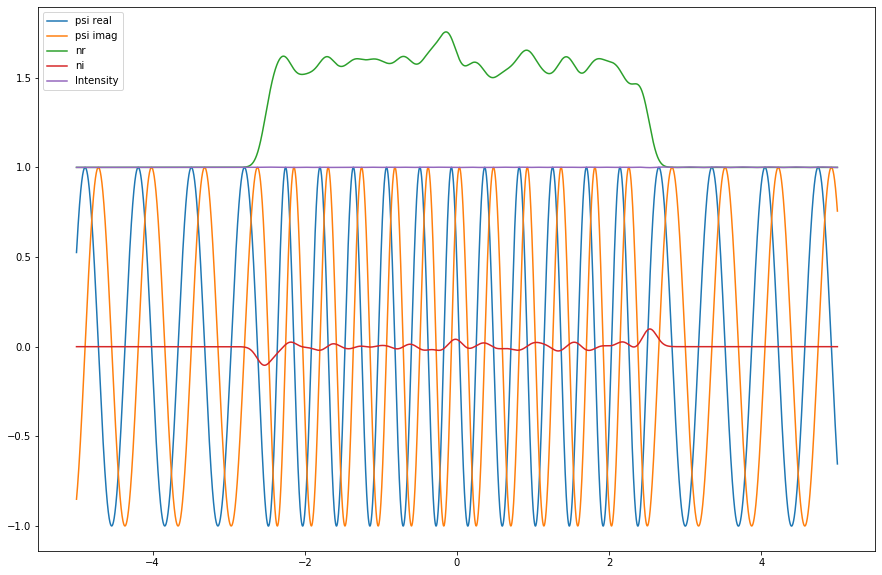

In [19]:
Int = plot_psi(grid, stepsize, n = nr + 1j*ni, Amp = 1, k=k)

And the intensity with the predicted potential like this...

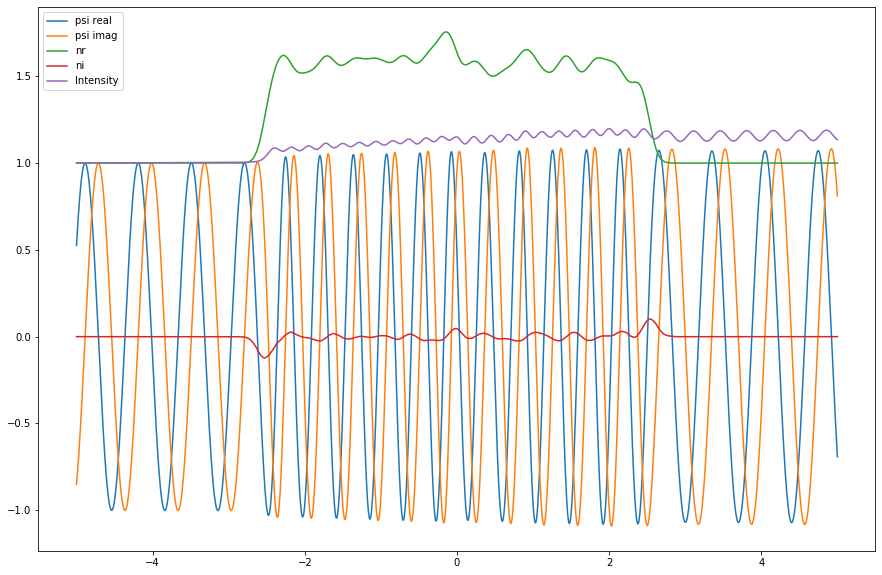

In [20]:
Int_pred = plot_psi(grid, stepsize, n = nr + 1j*ni_pred, Amp = 1, k=k)
plt.savefig(path_plots + which_model + '_CI.pdf')

The differences between the predicted potentials and intensities like this...

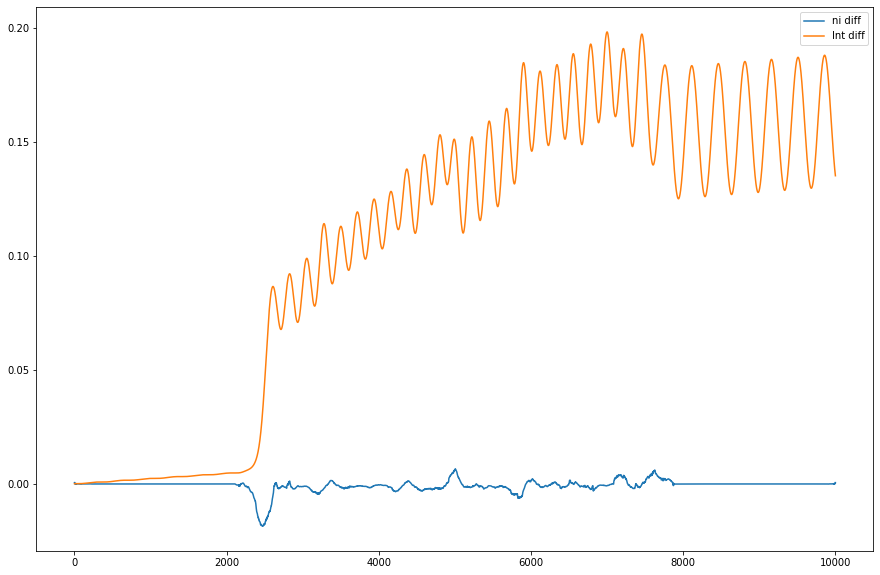

In [21]:
plt.plot(ni_pred-ni, label = 'ni diff')
plt.plot(Int_pred - Int, label = 'Int diff')
plt.legend(loc='upper right')
plt.savefig(path_plots + which_model + '_Diff.pdf')

The label intensity vs the predicted

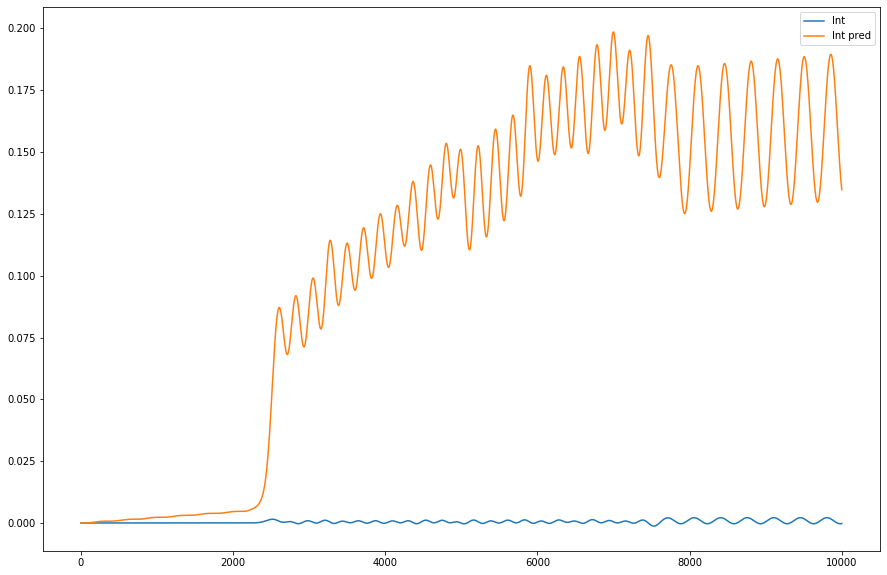

In [22]:
plt.plot(Int -1, label = 'Int')
plt.plot(Int_pred -1, label = 'Int pred')
plt.legend(loc='upper right')

### Special Cases

In [23]:
plt.rcParams['figure.figsize'] = [15,10]

knr:  torch.Size([8, 10001])
ni_pred:  torch.Size([10000])
nr:  torch.Size([10001])
22.666378


array([1.        , 1.        , 1.        , ..., 1.00013489, 1.00016744,
       1.00019966])

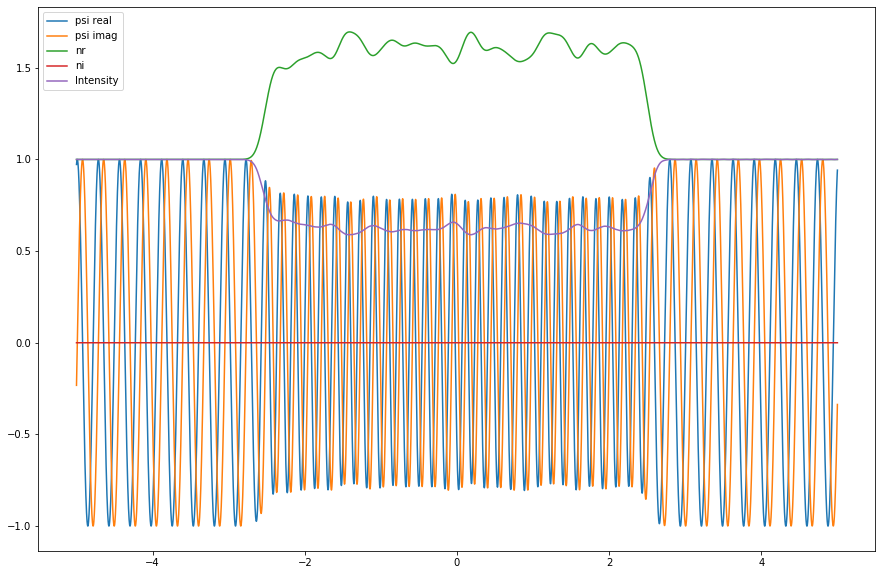

In [24]:
# numerov wave to just nr (what about the intensity? it shouldnt be wave-y)

idx = 0

item = next(iter(validation_loader))

knr = item['k_n_r']
print('knr: ', knr.size())
ni_pred = model(knr)[idx]
print('ni_pred: ', ni_pred.size())

nr = knr[idx]
print('nr: ', nr.size())

k = knr[idx][0].cpu().numpy()
print(k)
n = DeNorm(nr.cpu().numpy() , nr_mean, nr_std)# + 1j*ni_pred.detach().numpy()
plot_psi(grid, stepsize, n, Amp=1, k=k, plot = True)

knr:  tensor([[26.0500, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
        [ 9.1319, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
        [29.4336, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
        ...,
        [22.6664, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
        [ 9.1319, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
        [26.0500, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189]],
       device='cuda:0')
real k:  tensor(5., device='cuda:0')
tensor([[22.6664, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
        [22.6664, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
        [22.6664, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
        ...,
        [22.6664, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
        [22.6664, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189],
        [22.6664, -1.0189, -1.0189,  ..., -1.0189, -1.0189, -1.0189]],
       device='cuda:0')
ni_pred:  torch.Size([10000])
22.666378
8

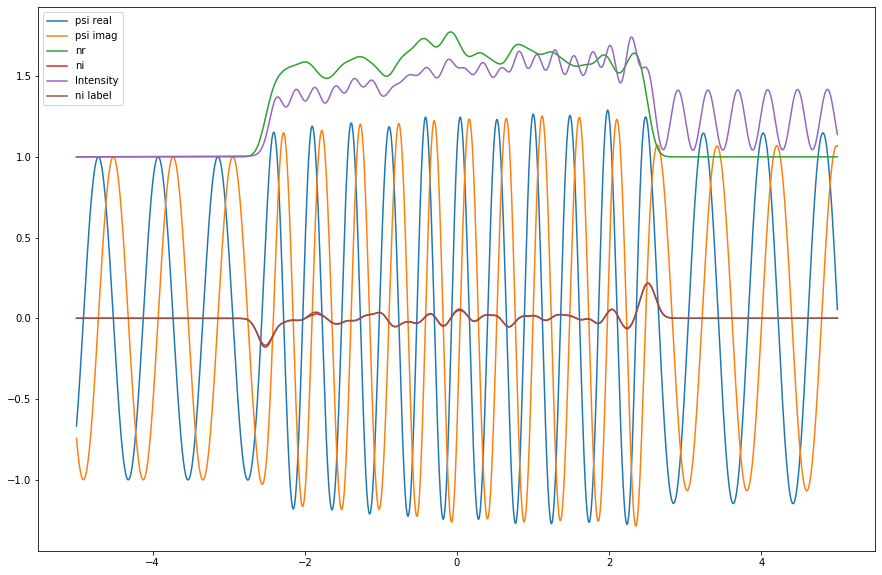

In [25]:
# predict ni for other k - does that work...?

idx = 3

item = next(iter(validation_loader))

knr = item['k_n_r']
print('knr: ', knr)

ni = DeNorm(item['n_i'][idx].detach().cpu().numpy(), ni_mean, ni_std)
print('real k: ', DeNorm(knr[idx][0], nr_mean, nr_std ) )

knr[:,0] = (8 - nr_mean)/nr_std # normalize
print(knr)

ni_pred = model(knr)[idx]
print('ni_pred: ', ni_pred.size())

print(knr[idx][0].cpu().numpy())
k = knr[idx][0].cpu().numpy()
print(k*nr_std + nr_mean)
nr = DeNorm(knr[idx].cpu().numpy(), nr_mean, nr_std)[1:]
ni_pred = DeNorm(ni_pred.detach().cpu().numpy(), ni_mean, ni_std)
n = nr + 1j*ni_pred
plot_psi(grid, stepsize, n, Amp=1, k=k*nr_std + nr_mean, plot = True)
#plt.plot(grid, ni_pred, label='ni')
plt.plot(grid, ni, label='ni label')
plt.legend(loc='upper left')

### Test

In [43]:
generate_init_data(500, path = path_test_data, x = grid, dx = stepsize)

Generating Pot Nmbr  0 , Runtime since last:  7.3909759521484375e-06 , Runtime so far:  7.62939453125e-06
Generating Pot Nmbr  100 , Runtime since last:  10.717503309249878 , Runtime so far:  10.717511653900146
Generating Pot Nmbr  200 , Runtime since last:  10.701054096221924 , Runtime so far:  21.41856622695923
Generating Pot Nmbr  300 , Runtime since last:  10.626531839370728 , Runtime so far:  32.045098066329956
Generating Pot Nmbr  400 , Runtime since last:  10.668453693389893 , Runtime so far:  42.71355175971985


In [26]:
nr_mean_test, nr_std_test, ni_mean_test, ni_std_test = calc_mean_std(500, path_test_data)

In [27]:
transform_test = transforms.Compose([Normalize((nr_mean_test, ni_mean_test), (nr_std_test, ni_std_test)),
                                    ToTensor(device)
                                   ])

In [28]:
initial_dataset_test = InitialDataset(csv_file = path_test_data + 'k_values.csv', 
                                   root_dir = path_test_data,
                                   transform = transform_test)

55
0.09066158533096313


<function matplotlib.pyplot.show(*args, **kw)>

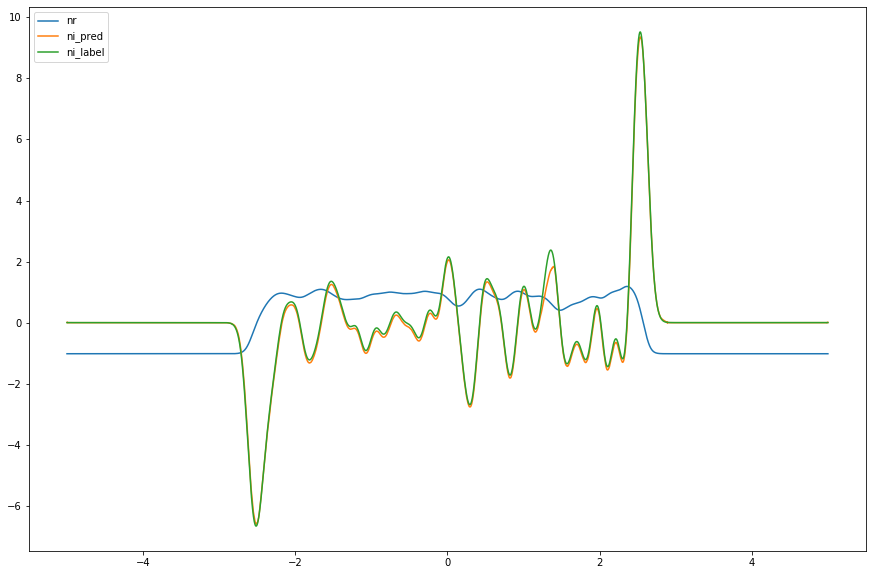

In [44]:
idx = np.random.randint(500)
print(idx)

data = initial_dataset_test[idx]['k_n_r'].view(1,-1)
out = model(data)
label = initial_dataset_test[idx]['n_i']

criterion = torch.nn.MSELoss()
print(criterion(out[0],label).item() * 8)

plt.plot(grid, data[0][1:].detach().cpu().numpy(), label='nr')
plt.plot(grid, out[0].detach().cpu().numpy(), label = 'ni_pred')
plt.plot(grid, label.detach().cpu().numpy(), label = 'ni_label')
plt.legend(loc='upper left')
plt.show


### Create Dataset for Corrector Unit

In [ ]:
if do_create_corrector_data:
    keys = generate_corr_data(model, train_loader, validation_loader, path_corrector_data, 
                       grid, stepsize, nr_mean, nr_std, ni_mean, ni_std)
else: 
    keys = ['k_n_r', 'n_i', 'n_i_pred', 'n_i_difference', 'I_pred']

In [ ]:
means_corr, stds_corr = calc_mean_std_corr(path_corrector_data, size_dataset, keys)

transform = transforms.Compose([NormalizeCorr(means_corr, stds_corr),
                                ToDevice(device)
                                   ])

corrector_dataset = CorrectorDataset(root_dir = path_corrector_data, 
                                     size_dataset = size_dataset, 
                                     keys = ['k_n_r', 'n_i', 'n_i_pred', 'n_i_difference', 'I_pred'], 
                                     transform = transform)

In [ ]:
corrector_dataset[0]

In [ ]:
#show that it worked
idx = 1
sample = corrector_dataset[idx]

for key in sample.keys():
    print(key + ': ', sample[key])
    print(sample[key].size())
    print(sample[key].is_cuda)
    plt.plot(grid,sample[key].cpu().detach().numpy()[-10000:], label = key)

plt.legend(loc='upper right')

### Create DataLoaders

In [ ]:
train_loader_corr, validation_loader_corr = get_dataloaders(corrector_dataset, 
                                                            batch_size = 8, 
                                                            validation_split = validation_split, 
                                                            shuffle_dataset = True, 
                                                            random_seed= 42)

In [ ]:
#evtl soll nicht ein neues Model erstellt, sondern ein altes geladen werden!

if do_load_model_corr:
    corrector = torch.load(path_model_corr, map_location=device)
else:
    #sonst wird jetzt neues Model erstellt
    if which_model_corr == 'FNN':
        corrector = FNN(n_feature=30001, n_hidden=3000, n_output=10000) #cat 0...I_pred , 1...ni_pred , 2...nr
    else:
        corrector = UNet(n_channels=3, n_classes=1, label_len = nmbr_points) #channels 0...I_pred , 1...ni_pred , 2...nr

print(corrector)

In [ ]:
corrector.to(device)
next(corrector.parameters()).is_cuda

### Train Corrector

In [ ]:
if do_train_model_corr:
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    corrector, info = train_corrector(nmbr_epochs, corrector, criterion, optimizer,
                                      train_loader_corr, validation_loader_corr, which_model = which_model_corr,
                                      early_stopping=30, path=path_model_corr)

### Corrector Evaluation

In [ ]:
model.eval()

In [ ]:
nr, ni, ni_pred, k = plot_correction(validation_loader_corr, corrector, grid, 
                                     means_corr, stds_corr, 
                                     idx=0, k=None)
plt.savefig(path_plots + which_model + '_Correction.pdf')

In [ ]:
###GAUNet!

In [ ]:
###finally: try again the real physical wave shooting thing with reflections and stuff